In [1]:
import numpy as np
from numpy import linalg as LA
import scipy
import itertools as it

In [2]:
counter = {
    'function_eval':0,
    'derivative_eval':0,
    'hessian_eval':0
}

def total_effort(number_of_func_param):
    n = number_of_func_param
    return counter['function_eval']+(counter['derivative_eval']*n)+(counter['hessian_eval']* n**2)

def count_fnc_call_decorator(fnc):
    def count_wrapper(*args, **kwargs):
        global counter
        fnc(*args,**kwargs)
        counter['function_eval'] += 1
        return fnc(*args,**kwargs)
    return count_wrapper

def reset_function_counter():
    global counter
    counter['function_eval']=0
    counter['derivative_eval']=0
    counter['hessian_eval']=0

In [3]:
def ek(k,dim):
    ek = np.zeros(dim)
    ek[k]=1
    return ek

In [4]:
def grad_neumeric(f,values,h=0.00001):
    dim = len(values)
    derviative = lambda val,pos: (f(*(val+h*pos))-f(*val))/h
    return np.array([derviative(values,ek(i,dim))  for i in range(dim)])

In [5]:
test_f = lambda x,y,z: x**2+y**2+z**2
test_val = np.array([1,2,3])
grad_approx = grad_neumeric(test_f,test_val)
grad_approx

array([2.00001, 4.00001, 6.00001])

In [6]:
def hassian_neumeric(f,values,h=0.00001):
    der_hessian_at_val = []
    der_hessian = lambda vec, eki,ekj: (f(*(vec+h*ekj+h*eki))-f(*(vec+h*ekj))-f(*(vec+h*eki))+f(*vec))/h**2 
    dim = len(values)
    for i in range(dim):
       for j in range(dim):
           val = (der_hessian(values,ek(i,dim),ek(j,dim)))
           der_hessian_at_val.append(val)
    der_hessian_at_val = np.array(der_hessian_at_val).reshape(dim,dim)
    return der_hessian_at_val

In [7]:
test_hf = lambda x,y: x**2+y**2
test_hval = np.array([1,2])
print(grad_neumeric(test_hf,test_hval))
print(hassian_neumeric(test_hf,test_hval))

[2.00001 4.00001]
[[2.00000017 0.        ]
 [0.         2.00000017]]


In [8]:
def gradient_at_val(f,gradient_f,values):
    global counter
    counter['derivative_eval'] += 1
    
    grad = []
    if gradient_f is None:
        return np.array(grad_neumeric(f,values))
    for function in gradient_f:
        gradient = function(*values)
        grad.append(gradient)
    
    
    return np.array(grad)

In [9]:
def hassian_at_val(f,gradient2d_f,values):
    global counter
    counter['hessian_eval'] += 1
    
    hassian = []
    if gradient2d_f is None:
        return hassian_neumeric(f,values)
    for gradient_f in gradient2d_f:
        grad = gradient_at_val(f,gradient_f,values)
        hassian.append(grad)
    return np.array(hassian)

In [10]:
def inverse_update_BFGS(Hk1,Hk,f,gradient_f,xk1,xk):
      = gradient_at_val(f,gradient_f,xk1)
    grad_at_xk = gradient_at_val(f,gradient_f,xk)
    yk = grad_at_xk1 - grad_at_xk
    sk = xk1-xk
    
    Hk1 = LA.inv(Hk1)
    Hk = LA.inv(Hk)
    
    common_denominator = np.outer(yk.T,sk)
    term1 = (np.outer((sk-np.dot(Hk,yk)),sk.T) + np.outer(sk, (sk-np.dot(Hk,yk)).T)) / common_denominator
    term2 = np.dot(np.outer((sk-np.dot(Hk1,yk)).T,yk),np.outer(sk,sk.T))/common_denominator**2

    Uk = term1 - term2

    Hk1 = Hk+ Uk
    return Hk1

In [11]:
def gradient_direction(function,gradient_f,gradient2d_f,values,Hk=None,direction_method='newton'):
    dk = []
    grad = gradient_at_val(function,gradient_f,values)
    if direction_method == 'newton':
        dk = - np.dot(LA.inv(hassian_at_val(function,gradient2d_f,values)), grad)
        if - np.dot(grad.T,dk)/(LA.norm(grad)*LA.norm(dk)) < 0.1:
            dk = - grad
    elif direction_method == 'quasi-newton':
        dk = np.dot(-Hk,grad)
        if - np.dot(grad.T,dk)/(LA.norm(grad)*LA.norm(dk)) < 0.1:
            dk = - grad
    else:
        dk = - grad
    return dk
        

In [12]:
def descent_direction(f,gradient_f,values):
    grad = gradient_at_val(f,gradient_f,values)
    p =  - (LA.norm(grad))**2
    return p

In [13]:
def armijo_step_algorithm(f,gradient_f,dk,values,delta):
    ro = 1
    grad_at_values = gradient_at_val(f,gradient_f,values).T
    while f(*(values+ro*dk)) <= f(*values)+ro*delta*np.dot(grad_at_values,dk):
        ro *= 2
    
    while f(*(values+ro*dk)) > f(*values)+ro*delta*np.dot(grad_at_values,dk):
        ro /= 2
    return ro

In [14]:
# Bazaray shetty function
# f = lambda x,y: (x-2)**4 + (x-2*y)**2
# f = count_fnc_call_decorator(f)
# dfx = lambda x,y: 4*(x-2)**3+2*(x-2*y)
# dfy = lambda x,y: -4*(x-2*y)

# dfx11 = lambda x,y: 12*(x-2)**2+2
# dfx12 = lambda x,y: -4

# dfx21 = lambda x,y: -4
# dfx22 = lambda x,y: 8

In [15]:
# rosenbrook function
f = lambda x,y : 100*(y-x*x)**2 + (1-x)**2
f = count_fnc_call_decorator(f)
dfx = lambda x,y: -400*x*(y-x*x) + 2*x - 2
dfy = lambda x,y: 200*(y-x*x)

dfx11 = lambda x,y: -400*(y-3*x**2)+2
dfx12 = lambda x,y: -400*x

dfx21 = lambda x,y: -400*x
dfx22 = lambda x,y: 200

In [16]:
print(f'dfx numeric: {grad_neumeric(f,[1,2])} ')
print(f'dfx: {dfx(1,2)}  dfy:{dfy(1,2)}')

dfx numeric: [-399.99798996  200.001     ] 
dfx: -400  dfy:200


In [17]:
print(f'dfx numeric: {hassian_neumeric(f,[1,2])} ')
print(f'dfx11: {dfx11(1,2)}  dfx12:{dfx12(1,2)} dfx21:{dfx21(1,2)} dfx22:{dfx22(1,2)}')

dfx numeric: [[ 402.02365881 -400.00216472]
 [-400.00216472  199.99987444]] 
dfx11: 402  dfx12:-400 dfx21:-400 dfx22:200


In [18]:
from numpy import linalg as LA
def general_descent(iteration,function,gradient_f,gradient2d_f,initial,direction_method='newton'):
    Hk = None
    Hk1 = None
    xk = initial
    counter = 0
    xk1 = 0
    delta = 10**(-3)

    if direction_method == 'quasi-newton':
        Hk = LA.inv(hassian_at_val(function,gradient2d_f,initial))
        Hk1 = Hk

    while counter <=iteration:
        dk = gradient_direction(function,gradient_f,gradient2d_f,xk,Hk,direction_method=direction_method)
        step_size = armijo_step_algorithm(function,gradient_f,dk,xk,delta)
        xk1 = xk + step_size*dk
       
        if direction_method == 'quasi-newton':
            Hk1 = inverse_update_BFGS(Hk1,Hk,function,gradient_f,xk1,xk)
            Hk=Hk1
        
        xk = xk1
        print('xk1 at iterate: {}--->: {}'.format(counter,xk1))
        print('dk at iterate: {}--->: {}'.format(counter,dk))
        print('step_size at iterate: {}--->: {}'.format(counter,step_size))
        counter += 1
        if LA.norm(gradient_at_val(function,gradient_f,xk))<=0.01:
            break
    return xk1

In [19]:
general_descent(10000,f,np.array([dfx,dfy]),np.array([[dfx11,dfx12],[dfx21,dfx22]]),np.array([0,10]),direction_method='newton')

xk1 at iterate: 0--->: [-0.00050025  0.        ]
dk at iterate: 0--->: [-5.00250125e-04 -1.00000000e+01]
step_size at iterate: 0--->: 1.0
xk1 at iterate: 1--->: [ 0.24961229 -0.00025018]
dk at iterate: 1--->: [ 1.00045018 -0.0010007 ]
step_size at iterate: 1--->: 0.25
xk1 at iterate: 2--->: [0.36068791 0.18031445]
dk at iterate: 2--->: [0.05553781 0.09028231]
step_size at iterate: 2--->: 2.0
xk1 at iterate: 3--->: [0.28999676 0.07910088]
dk at iterate: 3--->: [-0.07069115 -0.10121357]
step_size at iterate: 3--->: 1.0
xk1 at iterate: 4--->: [0.4675466  0.18457726]
dk at iterate: 4--->: [0.35509967 0.21095275]
step_size at iterate: 4--->: 0.5
xk1 at iterate: 5--->: [1.01333688 0.96712255]
dk at iterate: 5--->: [0.06822378 0.09781816]
step_size at iterate: 5--->: 8.0
xk1 at iterate: 6--->: [1.01230667 1.02476374]
dk at iterate: 6--->: [-0.00103021  0.05764119]
step_size at iterate: 6--->: 1.0
xk1 at iterate: 7--->: [1.00000261 0.99985383]
dk at iterate: 7--->: [-0.01230406 -0.0249099 ]
st

array([1.00000008, 1.00000015])

In [20]:
print(f'function call for newton with derivative and hessian functions{counter}')
print(total_effort(2))
reset_function_counter()

function call for newton with derivative and hessian functions{'function_eval': 98, 'derivative_eval': 45, 'hessian_eval': 9}
224


In [21]:
general_descent(20000,f,None,None,np.array([0,10]),direction_method='newton')

xk1 at iterate: 0--->: [-0.00050525 -0.00011075]
dk at iterate: 0--->: [-5.05251010e-04 -1.00001108e+01]
step_size at iterate: 0--->: 1.0
xk1 at iterate: 1--->: [ 0.2441883  -0.00032907]
dk at iterate: 1--->: [ 9.78774212e-01 -8.73253118e-04]
step_size at iterate: 1--->: 0.25
xk1 at iterate: 2--->: [0.36046982 0.17636526]
dk at iterate: 2--->: [0.05814076 0.08834716]
step_size at iterate: 2--->: 2.0
xk1 at iterate: 3--->: [0.28333041 0.07431986]
dk at iterate: 3--->: [-0.07713941 -0.1020454 ]
step_size at iterate: 3--->: 1.0
xk1 at iterate: 4--->: [0.44658878 0.16980925]
dk at iterate: 4--->: [0.32651673 0.19097877]
step_size at iterate: 4--->: 0.5
xk1 at iterate: 5--->: [0.76552571 0.57318891]
dk at iterate: 5--->: [0.07973423 0.10084492]
step_size at iterate: 5--->: 4.0
xk1 at iterate: 6--->: [0.89564018 0.79807355]
dk at iterate: 6--->: [0.06505724 0.11244232]
step_size at iterate: 6--->: 2.0
xk1 at iterate: 7--->: [0.89317424 0.7996723 ]
dk at iterate: 7--->: [-1.26256224  0.818556

array([0.99833482, 0.99666587])

In [22]:
print(f'function call for newton with neumerical approximation of derivative and hessian{counter}')
print(total_effort(2))
reset_function_counter()

function call for newton with neumerical approximation of derivative and hessian{'function_eval': 466, 'derivative_eval': 36, 'hessian_eval': 12}
586


In [23]:
general_descent(10000,f,np.array([dfx,dfy]),np.array([[dfx11,dfx12],[dfx21,dfx22]]),np.array([0,10]),direction_method='quasi-newton')

xk1 at iterate: 0--->: [-0.00050025  0.        ]
dk at iterate: 0--->: [-5.00250125e-04 -1.00000000e+01]
step_size at iterate: 0--->: 1.0
xk1 at iterate: 1--->: [2.49624819e-01 6.25625469e-06]
dk at iterate: 1--->: [2.00100055e+00 5.00500375e-05]
step_size at iterate: 1--->: 0.125
xk1 at iterate: 2--->: [0.07295486 0.010257  ]
dk at iterate: 2--->: [-23156.48518558   1343.58610503]
step_size at iterate: 2--->: 7.62939453125e-06
xk1 at iterate: 3--->: [ 0.10417503 -0.0051636 ]
dk at iterate: 3--->: [ 1.99809131 -0.98691871]
step_size at iterate: 3--->: 0.015625
xk1 at iterate: 4--->: [ 0.18810177 -0.00469496]
dk at iterate: 4--->: [21.48524548  0.11997074]
step_size at iterate: 4--->: 0.00390625
xk1 at iterate: 5--->: [ 0.14876464 -0.00677597]
dk at iterate: 5--->: [-20623.9862036   -1091.04720364]
step_size at iterate: 5--->: 1.9073486328125e-06
xk1 at iterate: 6--->: [0.14862668 0.03839104]
dk at iterate: 6--->: [-0.01765858  5.78137812]
step_size at iterate: 6--->: 0.0078125
xk1 at i

dk at iterate: 63--->: [ 0.9413699  -0.02343558]
step_size at iterate: 63--->: 0.0078125
xk1 at iterate: 64--->: [0.54594599 0.30003936]
dk at iterate: 64--->: [-0.87705786  1.61849699]
step_size at iterate: 64--->: 0.00390625
xk1 at iterate: 65--->: [0.56370737 0.30782116]
dk at iterate: 65--->: [0.03552276 0.0155636 ]
step_size at iterate: 65--->: 0.5
xk1 at iterate: 66--->: [0.55582133 0.31403176]
dk at iterate: 66--->: [-2067.27790472  1628.070491  ]
step_size at iterate: 66--->: 3.814697265625e-06
xk1 at iterate: 67--->: [0.56371582 0.31005175]
dk at iterate: 67--->: [ 2.02098881 -1.0188809 ]
step_size at iterate: 67--->: 0.00390625
xk1 at iterate: 68--->: [0.56032115 0.31608595]
dk at iterate: 68--->: [-0.86903642  1.54475422]
step_size at iterate: 68--->: 0.00390625
xk1 at iterate: 69--->: [0.5656176  0.31442488]
dk at iterate: 69--->: [ 1.35589147 -0.42523271]
step_size at iterate: 69--->: 0.00390625
xk1 at iterate: 70--->: [0.56415186 0.31872049]
dk at iterate: 70--->: [-0.375

xk1 at iterate: 130--->: [0.67590313 0.45704705]
dk at iterate: 130--->: [  7.89685723 168.96111642]
step_size at iterate: 130--->: 7.62939453125e-06
xk1 at iterate: 131--->: [0.67596942 0.45627724]
dk at iterate: 131--->: [ 0.01697232 -0.19707128]
step_size at iterate: 131--->: 0.00390625
xk1 at iterate: 132--->: [0.67601154 0.45774566]
dk at iterate: 132--->: [  44.16203127 1539.74820819]
step_size at iterate: 132--->: 9.5367431640625e-07
xk1 at iterate: 133--->: [0.67933918 0.45715655]
dk at iterate: 133--->: [ 0.85187656 -0.15081077]
step_size at iterate: 133--->: 0.00390625
xk1 at iterate: 134--->: [0.67835023 0.45933146]
dk at iterate: 134--->: [-518.49572733 1140.2788953 ]
step_size at iterate: 134--->: 1.9073486328125e-06
xk1 at iterate: 135--->: [0.68162168 0.46062455]
dk at iterate: 135--->: [0.41874537 0.16551492]
step_size at iterate: 135--->: 0.0078125
xk1 at iterate: 136--->: [0.68054265 0.46252341]
dk at iterate: 136--->: [-282.86083898  497.77595101]
step_size at iterat

xk1 at iterate: 195--->: [0.75256924 0.56646171]
dk at iterate: 195--->: [-0.19179611  0.30481011]
step_size at iterate: 195--->: 0.00390625
xk1 at iterate: 196--->: [0.75283312 0.5656319 ]
dk at iterate: 196--->: [  4.32348991 -13.59560551]
step_size at iterate: 196--->: 6.103515625e-05
xk1 at iterate: 197--->: [0.83049075 0.6782128 ]
dk at iterate: 197--->: [0.15531524 0.22516179]
step_size at iterate: 197--->: 0.5
xk1 at iterate: 198--->: [0.8236901 0.6827058]
dk at iterate: 198--->: [-3.48192981  2.30041595]
step_size at iterate: 198--->: 0.001953125
xk1 at iterate: 199--->: [0.82710755 0.68104939]
dk at iterate: 199--->: [ 1.74973509 -0.84808309]
step_size at iterate: 199--->: 0.001953125
xk1 at iterate: 200--->: [0.82580721 0.68224373]
dk at iterate: 200--->: [-0.66577343  0.6115035 ]
step_size at iterate: 200--->: 0.001953125
xk1 at iterate: 201--->: [0.82667228 0.68213194]
dk at iterate: 201--->: [ 0.44291552 -0.05723487]
step_size at iterate: 201--->: 0.001953125
xk1 at iterat

xk1 at iterate: 272--->: [0.95391763 0.90998692]
dk at iterate: 272--->: [-0.0820394   0.09112656]
step_size at iterate: 272--->: 0.001953125
xk1 at iterate: 273--->: [0.95576954 0.91457832]
dk at iterate: 273--->: [0.11852216 0.29384981]
step_size at iterate: 273--->: 0.015625
xk1 at iterate: 274--->: [0.9558933  0.91355103]
dk at iterate: 274--->: [ 0.12672502 -1.05194497]
step_size at iterate: 274--->: 0.0009765625
xk1 at iterate: 275--->: [0.95588379 0.91376952]
dk at iterate: 275--->: [-0.03892158  0.8949268 ]
step_size at iterate: 275--->: 0.000244140625
xk1 at iterate: 276--->: [0.95609772 0.91374777]
dk at iterate: 276--->: [ 0.1095282  -0.01113932]
step_size at iterate: 276--->: 0.001953125
xk1 at iterate: 277--->: [0.95598905 0.91389428]
dk at iterate: 277--->: [-0.05563889  0.07501506]
step_size at iterate: 277--->: 0.001953125
xk1 at iterate: 278--->: [0.9560716  0.91386357]
dk at iterate: 278--->: [ 0.00528324 -0.00196538]
step_size at iterate: 278--->: 0.015625
xk1 at ite

xk1 at iterate: 340--->: [0.97235018 0.94477162]
dk at iterate: 340--->: [ 0.2713057  -0.11058952]
step_size at iterate: 340--->: 0.001953125
xk1 at iterate: 341--->: [0.97238125 0.94596815]
dk at iterate: 341--->: [0.00795329 0.30631329]
step_size at iterate: 341--->: 0.00390625
xk1 at iterate: 342--->: [0.97282556 0.94579516]
dk at iterate: 342--->: [ 0.22749155 -0.0885733 ]
step_size at iterate: 342--->: 0.001953125
xk1 at iterate: 343--->: [0.97247994 0.94602735]
dk at iterate: 343--->: [-0.17695846  0.11888428]
step_size at iterate: 343--->: 0.001953125
xk1 at iterate: 344--->: [0.97282305 0.94590622]
dk at iterate: 344--->: [ 0.1756723  -0.06202297]
step_size at iterate: 344--->: 0.001953125
xk1 at iterate: 345--->: [0.97256556 0.94609312]
dk at iterate: 345--->: [-0.13183533  0.09569532]
step_size at iterate: 345--->: 0.001953125
xk1 at iterate: 346--->: [0.97283179 0.94601134]
dk at iterate: 346--->: [ 0.1363108  -0.04186963]
step_size at iterate: 346--->: 0.001953125
xk1 at it

xk1 at iterate: 401--->: [0.98727778 0.97485242]
dk at iterate: 401--->: [ -3.6098485  807.72014629]
step_size at iterate: 401--->: 4.76837158203125e-07
xk1 at iterate: 402--->: [0.98743161 0.97479969]
dk at iterate: 402--->: [ 0.0787586  -0.02700059]
step_size at iterate: 402--->: 0.001953125
xk1 at iterate: 403--->: [0.98730984 0.97488621]
dk at iterate: 403--->: [-0.0623469   0.04429861]
step_size at iterate: 403--->: 0.001953125
xk1 at iterate: 404--->: [0.98744078 0.974845  ]
dk at iterate: 404--->: [ 0.06704263 -0.0210989 ]
step_size at iterate: 404--->: 0.001953125
xk1 at iterate: 405--->: [0.98733995 0.97492089]
dk at iterate: 405--->: [-0.05162283  0.03885867]
step_size at iterate: 405--->: 0.001953125
xk1 at iterate: 406--->: [0.98745166 0.97488937]
dk at iterate: 406--->: [ 0.05719593 -0.01614228]
step_size at iterate: 406--->: 0.001953125
xk1 at iterate: 407--->: [0.98736844 0.97495633]
dk at iterate: 407--->: [-0.04261172  0.03428441]
step_size at iterate: 407--->: 0.00195

xk1 at iterate: 464--->: [0.98883923 0.9777465 ]
dk at iterate: 464--->: [ 0.0031503  -0.00147831]
step_size at iterate: 464--->: 0.0078125
xk1 at iterate: 465--->: [0.98883895 0.97783482]
dk at iterate: 465--->: [-3.64460594e-05  1.13051642e-02]
step_size at iterate: 465--->: 0.0078125
xk1 at iterate: 466--->: [0.98884948 0.97777486]
dk at iterate: 466--->: [ 0.34525512 -1.96503901]
step_size at iterate: 466--->: 3.0517578125e-05
xk1 at iterate: 467--->: [0.98904563 0.97838044]
dk at iterate: 467--->: [0.00313833 0.00968939]
step_size at iterate: 467--->: 0.0625
xk1 at iterate: 468--->: [0.98921915 0.97831436]
dk at iterate: 468--->: [ 0.08884128 -0.03383693]
step_size at iterate: 468--->: 0.001953125
xk1 at iterate: 469--->: [0.98907565 0.97840817]
dk at iterate: 469--->: [-0.07346977  0.04803358]
step_size at iterate: 469--->: 0.001953125
xk1 at iterate: 470--->: [0.98922459 0.97835445]
dk at iterate: 470--->: [ 0.0762575  -0.02750487]
step_size at iterate: 470--->: 0.001953125
xk1 

array([0.98966731, 0.97939587])

In [24]:
print(f'function call for quasi-newton with derivative and hessian functions{counter}')
print(total_effort(2))
reset_function_counter()

function call for quasi-newton with derivative and hessian functions{'function_eval': 11488, 'derivative_eval': 2547, 'hessian_eval': 1}
16586


In [25]:
general_descent(20000,f,None,None,np.array([0,10]),direction_method='quasi-newton')

xk1 at iterate: 0--->: [-0.00050525 -0.00011075]
dk at iterate: 0--->: [-5.05251010e-04 -1.00001108e+01]
step_size at iterate: 0--->: 1.0
xk1 at iterate: 1--->: [ 2.36761360e-01 -1.10642356e-04]
dk at iterate: 1--->: [1.66961534e+13 7.91880947e+06]
step_size at iterate: 1--->: 1.4210854715202004e-14
xk1 at iterate: 2--->: [0.09383222 0.00718678]
dk at iterate: 2--->: [-1198976.5196402     61215.18770331]
step_size at iterate: 2--->: 1.1920928955078125e-07
xk1 at iterate: 3--->: [0.20342744 0.00773625]
dk at iterate: 3--->: [1795.60803377    9.00260369]
step_size at iterate: 3--->: 6.103515625e-05
xk1 at iterate: 4--->: [0.16434054 0.00802516]
dk at iterate: 4--->: [-640.39978099    4.73354663]
step_size at iterate: 4--->: 6.103515625e-05
xk1 at iterate: 5--->: [0.18099177 0.00804872]
dk at iterate: 5--->: [69840.31726088    98.79961422]
step_size at iterate: 5--->: 2.384185791015625e-07
xk1 at iterate: 6--->: [0.17981172 0.04664919]
dk at iterate: 6--->: [-0.15104585  4.94085978]
step_

xk1 at iterate: 64--->: [0.58668764 0.34228233]
dk at iterate: 64--->: [ 0.06618598 -0.19507521]
step_size at iterate: 64--->: 0.015625
xk1 at iterate: 65--->: [0.68034835 0.43803555]
dk at iterate: 65--->: [0.37464282 0.38301288]
step_size at iterate: 65--->: 0.25
xk1 at iterate: 66--->: [0.66839113 0.44773607]
dk at iterate: 66--->: [-6.12209465  4.96666602]
step_size at iterate: 66--->: 0.001953125
xk1 at iterate: 67--->: [0.67200806 0.44695922]
dk at iterate: 67--->: [ 0.9259342  -0.19887179]
step_size at iterate: 67--->: 0.00390625
xk1 at iterate: 68--->: [0.66969592 0.45057689]
dk at iterate: 68--->: [-0.59190997  0.92612293]
step_size at iterate: 68--->: 0.00390625
xk1 at iterate: 69--->: [0.67445037 0.44894465]
dk at iterate: 69--->: [ 1.21713963 -0.41785433]
step_size at iterate: 69--->: 0.00390625
xk1 at iterate: 70--->: [0.67258929 0.45126248]
dk at iterate: 70--->: [-0.95287214  1.18673007]
step_size at iterate: 70--->: 0.001953125
xk1 at iterate: 71--->: [0.67594121 0.4610

xk1 at iterate: 123--->: [0.78312415 0.61171752]
dk at iterate: 123--->: [ 0.64852601 -0.13829795]
step_size at iterate: 123--->: 0.001953125
xk1 at iterate: 124--->: [0.78289276 0.61293698]
dk at iterate: 124--->: [-0.05923572  0.31218223]
step_size at iterate: 124--->: 0.00390625
xk1 at iterate: 125--->: [0.78772758 0.61732655]
dk at iterate: 125--->: [0.03867859 0.03511653]
step_size at iterate: 125--->: 0.125
xk1 at iterate: 126--->: [0.78658984 0.61856998]
dk at iterate: 126--->: [-0.58252544  0.6366391 ]
step_size at iterate: 126--->: 0.001953125
xk1 at iterate: 127--->: [0.78805863 0.61868607]
dk at iterate: 127--->: [0.3760108 0.0297176]
step_size at iterate: 127--->: 0.00390625
xk1 at iterate: 128--->: [0.78738449 0.62011985]
dk at iterate: 128--->: [-88.36073506 187.92815584]
step_size at iterate: 128--->: 7.62939453125e-06
xk1 at iterate: 129--->: [0.78769371 0.6193559 ]
dk at iterate: 129--->: [ 0.01979006 -0.04889278]
step_size at iterate: 129--->: 0.015625
xk1 at iterate:

xk1 at iterate: 185--->: [0.86987262 0.75659495]
dk at iterate: 185--->: [-0.22279116  0.27426648]
step_size at iterate: 185--->: 0.001953125
xk1 at iterate: 186--->: [0.8699632  0.75716571]
dk at iterate: 186--->: [0.37098192 2.33785333]
step_size at iterate: 186--->: 0.000244140625
xk1 at iterate: 187--->: [0.87227635 0.76323882]
dk at iterate: 187--->: [0.14804197 0.38867913]
step_size at iterate: 187--->: 0.015625
xk1 at iterate: 188--->: [0.87438629 0.76231   ]
dk at iterate: 188--->: [ 1.08028987 -0.47555793]
step_size at iterate: 188--->: 0.001953125
xk1 at iterate: 189--->: [0.87387583 0.76370589]
dk at iterate: 189--->: [-4.18172726 11.43514285]
step_size at iterate: 189--->: 0.0001220703125
xk1 at iterate: 190--->: [0.87439455 0.7636856 ]
dk at iterate: 190--->: [ 0.26558741 -0.01038557]
step_size at iterate: 190--->: 0.001953125
xk1 at iterate: 191--->: [0.87425009 0.76409171]
dk at iterate: 191--->: [-151.47495696  425.83068889]
step_size at iterate: 191--->: 9.536743164062

xk1 at iterate: 249--->: [0.93511247 0.8744878 ]
dk at iterate: 249--->: [1.62553112e-05 1.40711595e-03]
step_size at iterate: 249--->: 0.125
xk1 at iterate: 250--->: [0.93511432 0.87441974]
dk at iterate: 250--->: [  248.85997567 -9134.75584033]
step_size at iterate: 250--->: 7.450580596923828e-09
xk1 at iterate: 251--->: [0.93534701 0.87442523]
dk at iterate: 251--->: [0.11913724 0.00281038]
step_size at iterate: 251--->: 0.001953125
xk1 at iterate: 252--->: [0.9352787 0.8746584]
dk at iterate: 252--->: [-18337.07109537  62592.82707192]
step_size at iterate: 252--->: 3.725290298461914e-09
xk1 at iterate: 253--->: [0.93527874 0.87479282]
dk at iterate: 253--->: [7.26067213e-07 2.15065307e-03]
step_size at iterate: 253--->: 0.0625
xk1 at iterate: 254--->: [0.93555868 0.87477271]
dk at iterate: 254--->: [ 0.14332645 -0.01029823]
step_size at iterate: 254--->: 0.001953125
xk1 at iterate: 255--->: [0.93544004 0.87496503]
dk at iterate: 255--->: [-0.0607437  0.0984669]
step_size at iterate

xk1 at iterate: 319--->: [0.94093231 0.88549378]
dk at iterate: 319--->: [-0.22271654  0.70248546]
step_size at iterate: 319--->: 0.00048828125
xk1 at iterate: 320--->: [0.94098787 0.88531804]
dk at iterate: 320--->: [ 1.82052201 -5.75878624]
step_size at iterate: 320--->: 3.0517578125e-05
xk1 at iterate: 321--->: [0.94122899 0.88542361]
dk at iterate: 321--->: [0.06172599 0.02702699]
step_size at iterate: 321--->: 0.00390625
xk1 at iterate: 322--->: [0.94109248 0.88561244]
dk at iterate: 322--->: [-0.06988944  0.0966791 ]
step_size at iterate: 322--->: 0.001953125
xk1 at iterate: 323--->: [0.94128431 0.88562713]
dk at iterate: 323--->: [0.09821592 0.00752539]
step_size at iterate: 323--->: 0.001953125
xk1 at iterate: 324--->: [0.94118076 0.88596468]
dk at iterate: 324--->: [-6.78608936 22.12164138]
step_size at iterate: 324--->: 1.52587890625e-05
xk1 at iterate: 325--->: [0.94122888 0.88579297]
dk at iterate: 325--->: [ 0.02463596 -0.0879171 ]
step_size at iterate: 325--->: 0.00195312

xk1 at iterate: 385--->: [0.94596554 0.89450037]
dk at iterate: 385--->: [0.08619995 0.00884218]
step_size at iterate: 385--->: 0.001953125
xk1 at iterate: 386--->: [0.94589936 0.89471735]
dk at iterate: 386--->: [-0.06776857  0.22218851]
step_size at iterate: 386--->: 0.0009765625
xk1 at iterate: 387--->: [0.94591305 0.89465391]
dk at iterate: 387--->: [ 0.89727949 -4.1579533 ]
step_size at iterate: 387--->: 1.52587890625e-05
xk1 at iterate: 388--->: [0.94617734 0.89472625]
dk at iterate: 388--->: [0.06765671 0.01851974]
step_size at iterate: 388--->: 0.00390625
xk1 at iterate: 389--->: [0.94599226 0.8949295 ]
dk at iterate: 389--->: [-0.09475952  0.10406104]
step_size at iterate: 389--->: 0.001953125
xk1 at iterate: 390--->: [0.94621701 0.89491655]
dk at iterate: 390--->: [ 0.11507264 -0.00662729]
step_size at iterate: 390--->: 0.001953125
xk1 at iterate: 391--->: [0.94611694 0.89507479]
dk at iterate: 391--->: [-0.05123752  0.08101677]
step_size at iterate: 391--->: 0.001953125
xk1 

xk1 at iterate: 448--->: [0.95690926 0.91567295]
dk at iterate: 448--->: [-0.06081178  0.07375294]
step_size at iterate: 448--->: 0.001953125
xk1 at iterate: 449--->: [0.96010304 0.92027916]
dk at iterate: 449--->: [0.0511004  0.07369937]
step_size at iterate: 449--->: 0.0625
xk1 at iterate: 450--->: [0.96039234 0.92315684]
dk at iterate: 450--->: [0.2962473  2.94674459]
step_size at iterate: 450--->: 0.0009765625
xk1 at iterate: 451--->: [0.96048493 0.92231417]
dk at iterate: 451--->: [ 0.3792461  -3.45156025]
step_size at iterate: 451--->: 0.000244140625
xk1 at iterate: 452--->: [0.96045332 0.9224799 ]
dk at iterate: 452--->: [-0.00809172  0.04242664]
step_size at iterate: 452--->: 0.00390625
xk1 at iterate: 453--->: [0.96060757 0.92247431]
dk at iterate: 453--->: [ 0.07897149 -0.00286268]
step_size at iterate: 453--->: 0.001953125
xk1 at iterate: 454--->: [0.96056242 0.92263276]
dk at iterate: 454--->: [-2.95829984 10.38442522]
step_size at iterate: 454--->: 1.52587890625e-05
xk1 at

xk1 at iterate: 508--->: [0.96397171 0.92898865]
dk at iterate: 508--->: [0.06520049 0.00075586]
step_size at iterate: 508--->: 0.001953125
xk1 at iterate: 509--->: [0.96390749 0.92921832]
dk at iterate: 509--->: [-538.63444362 1926.63993693]
step_size at iterate: 509--->: 1.1920928955078125e-07
xk1 at iterate: 510--->: [0.9641126  0.92916808]
dk at iterate: 510--->: [ 0.00082043 -0.00020098]
step_size at iterate: 510--->: 0.25
xk1 at iterate: 511--->: [0.96409123 0.92957997]
dk at iterate: 511--->: [-44.8222843  863.80191087]
step_size at iterate: 511--->: 4.76837158203125e-07
xk1 at iterate: 512--->: [0.96430562 0.9295358 ]
dk at iterate: 512--->: [ 0.10976561 -0.02261402]
step_size at iterate: 512--->: 0.001953125
xk1 at iterate: 513--->: [0.96425385 0.92976764]
dk at iterate: 513--->: [-108.56219338  486.20770361]
step_size at iterate: 513--->: 4.76837158203125e-07
xk1 at iterate: 514--->: [0.96437276 0.92977266]
dk at iterate: 514--->: [0.06088122 0.00256849]
step_size at iterate:

array([0.99512147, 0.99027135])

In [26]:
print(f'function call for quasi-newton with neumerical approximation of derivative and hessian{counter}')
print(total_effort(2))
reset_function_counter()

function call for quasi-newton with neumerical approximation of derivative and hessian{'function_eval': 25204, 'derivative_eval': 2875, 'hessian_eval': 1}
30958


In [27]:
import matplotlib.pyplot as plt
x = np.arange(-10,10,1)
y = np.arange(-10,10,1)
fx = f(x,y)

In [28]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

def draw_function(x,y,f):
    fig = plt.figure(figsize=(20, 10))
    ax = plt.gca(projection='3d')
    s=0.5
    x,y = np.meshgrid(x,y)
    z= f(x,y)
    ax.plot_surface(x, y, z)

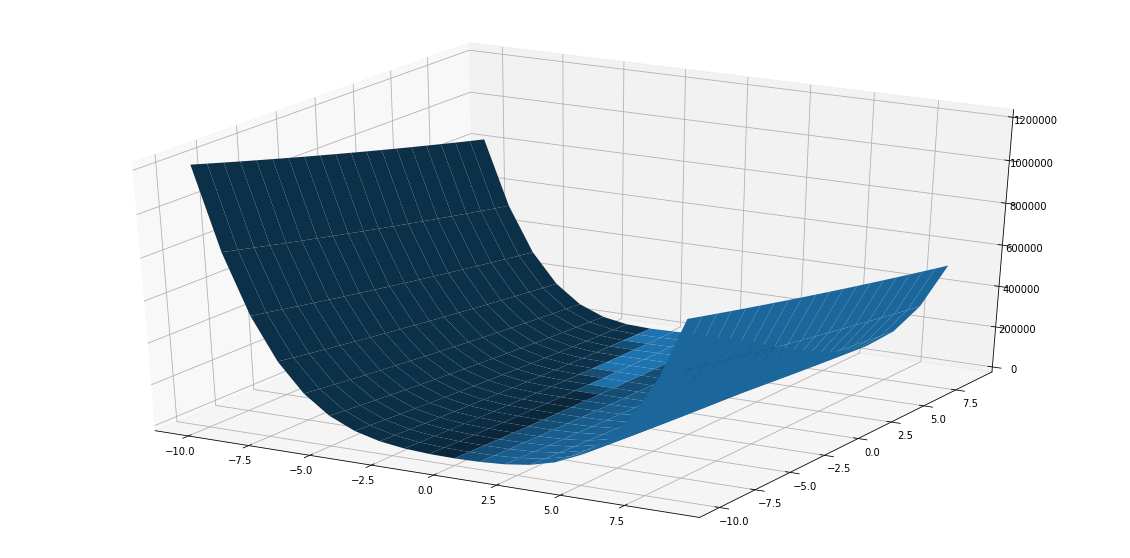

In [29]:
draw_function(x,y,f)